In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
data_path: str = "data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)
df

,ID,target,_type
0,2023-01-01 00:00:00,2.0,train
1,2023-01-01 01:00:00,1.0,train
2,2023-01-01 02:00:00,1.0,train
3,2023-01-01 03:00:00,1.0,train
4,2023-01-01 04:00:00,2.0,train
...,...,...,...
2787,2024-04-26 03:00:00,NaN,test
2788,2024-04-26 04:00:00,NaN,test
2789,2024-04-26 05:00:00,NaN,test
2790,2024-04-26 06:00:00,NaN,test


In [3]:
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:01<00:00, 65.95it/s]


In [4]:
df
missing_values=df.isnull().sum()
missing_values
missing_percentage= (missing_values)/len(df) *100
missing_percentage

sorted_missing_percentage=missing_percentage.sort_values(ascending=False)

# null 100 percent인 feature들
name_null=[]
for col, val in sorted_missing_percentage.items():
    if val==100:
        name_null.append(col)        
len(name_null)
for i in name_null:
    df=df.drop(columns=i)
df.shape
if 'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio' in df.columns:
    print('yes')
k='hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio'.split('_')
k

yes


['hourly',
 'market-data',
 'taker-buy-sell-stats',
 'all',
 'exchange',
 'taker',
 'buy',
 'ratio']

In [5]:
# cols_dict_open_interest = {}
# for i in df.columns:
#     parts=i.split("_"):
#     if len(parts)>=3 and "market-data" in parts and "open_interest" in parts:
#         cols_dict_open_interest[i]="_".join(parts[2:])
#     elif len(parts)<3:
#         cols_dict_open_interest[i]=i
# cols_dict_funding_rates ={}
# for i in df.columns:
#     parts=i.split("_"):
#     if len(parts)>=3 and "market-data" in parts and "funding-rates" in parts:
#         cols_dict_funding_rates[i]="_".join(parts[2:])
#     elif len(parts)<3:
#         cols_dict_funding_rates[i]=i
# taker-buy-sell and liquidation check

cols_dict : Dict[str,str] = {}
for i in df.columns:
    
    parts=i.split("_")
    if len(parts)>=3 and 'network-data' in parts:
        cols_dict[i]="_".join(parts[2:])
    elif len(parts) >= 3 and 'market-data' in parts:
        if 'exchange' in parts and 'all' and ('taker-buy-sell-stats' in parts or 'funding-rates' in parts):
            cols_dict[i] = "_".join(parts[2:])
        elif 'all' in parts and 'symbol' in parts and 'exchange' in parts and ('liquidations'  or 'open-interest' in parts):
            cols_dict[i] = "_".join(parts[2:])
        elif 'coinbase-premium-index' in parts:
            cols_dict[i] = "_".join(parts[2:])
    elif len(parts)<3:
        cols_dict[i]=i

cols_dict2: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "funding-rates_all_exchange_funding_rates": "funding_rates",
    "liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "addresses-count_addresses_count_active": "active_count",
    "addresses-count_addresses_count_receiver": "receiver_count",
    "addresses-count_addresses_count_sender": "sender_count",
}
len(cols_dict)
cols_dict
df = df[cols_dict.keys()].rename(cols_dict,axis=1)

In [6]:
for i in cols_dict2.keys():
    df = df.rename(columns={i: cols_dict2[i]})
df.columns

Index(['ID', 'target', '_type', 'block-bytes_block_bytes',
       'block-count_block_count', 'utxo-count_utxo_count',
       'difficulty_difficulty', 'active_count', 'sender_count',
       'receiver_count', 'hashrate_hashrate',
       'tokens-transferred_tokens_transferred_total',
       'tokens-transferred_tokens_transferred_mean',
       'tokens-transferred_tokens_transferred_median', 'open_interest',
       'blockreward_blockreward', 'blockreward_blockreward_usd',
       'funding_rates', 'buy_volume', 'sell_volume', 'buy_ratio', 'sell_ratio',
       'buy_sell_ratio', 'fees_fees_block_mean', 'fees_fees_block_mean_usd',
       'fees_fees_total', 'fees_fees_total_usd', 'fees_fees_reward_percent',
       'long_liquidations', 'short_liquidations', 'long_liquidations_usd',
       'short_liquidations_usd', 'coinbase_premium_gap',
       'coinbase_premium_index', 'fees-transaction_fees_transaction_mean',
       'fees-transaction_fees_transaction_mean_usd',
       'fees-transaction_fees_tran

## EDA
통계량 체크 fisrt
이상치 체크
눌값체크
eda 시간에 따른? 박스플롯?


In [7]:
eda=df[df["_type"]=="train"].drop(columns='_type')
eda.describe().T[0:15]

,count,mean,std,min,25%,50%,75%,max
target,8760.0,1.518379e+00,7.761899e-01,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00
block-bytes_block_bytes,8741.0,1.678415e+06,3.091730e+05,3.490182e+05,1.536214e+06,1.651432e+06,1.774045e+06,3.401656e+06
block-count_block_count,8760.0,6.112443e+00,2.496081e+00,0.000000e+00,4.000000e+00,6.000000e+00,8.000000e+00,1.700000e+01
utxo-count_utxo_count,8760.0,1.081966e+08,2.046060e+07,8.268952e+07,8.687761e+07,1.063398e+08,1.255724e+08,1.531721e+08
difficulty_difficulty,8741.0,5.194337e+13,9.201383e+12,3.409357e+13,4.684340e+13,5.232831e+13,5.711987e+13,7.200615e+13
active_count,8760.0,5.554523e+04,1.918195e+04,0.000000e+00,4.264550e+04,5.453150e+04,6.762725e+04,1.579810e+05
sender_count,8760.0,3.213800e+04,1.419697e+04,0.000000e+00,2.206750e+04,3.062750e+04,4.052125e+04,1.230050e+05
receiver_count,8760.0,2.827434e+04,1.000898e+04,0.000000e+00,2.127675e+04,2.748100e+04,3.430925e+04,8.125800e+04
hashrate_hashrate,8760.0,3.782604e+11,1.693080e+11,0.000000e+00,2.568262e+11,3.625397e+11,4.787106e+11,1.192349e+12
tokens-transferred_tokens_transferred_total,8760.0,3.430137e+04,1.675553e+04,0.000000e+00,2.280825e+04,3.172997e+04,4.260422e+04,2.596213e+05


In [8]:
eda.describe().T[15:30]

,count,mean,std,min,25%,50%,75%,max
funding_rates,8760.0,7.164723e-03,1.069997e-02,-9.756805e-02,2.939965e-03,6.678935e-03,1.065342e-02,6.702433e-02
buy_volume,8760.0,2.713101e+08,3.157187e+08,1.109395e+07,9.913835e+07,1.723347e+08,3.200573e+08,5.701178e+09
sell_volume,8760.0,2.728987e+08,3.144999e+08,8.559034e+06,9.997412e+07,1.724167e+08,3.212870e+08,5.343965e+09
buy_ratio,8760.0,4.981153e-01,4.619543e-02,2.283661e-01,4.666308e-01,4.983583e-01,5.285007e-01,7.289206e-01
sell_ratio,8760.0,5.018847e-01,4.619543e-02,2.710794e-01,4.714993e-01,5.016417e-01,5.333692e-01,7.716339e-01
buy_sell_ratio,8760.0,1.009950e+00,1.919599e-01,2.959514e-01,8.748739e-01,9.934546e-01,1.120894e+00,2.688956e+00
fees_fees_block_mean,8741.0,4.635134e-01,8.309327e-01,1.719315e-02,1.280430e-01,2.089834e-01,4.340841e-01,4.337500e+01
fees_fees_block_mean_usd,8741.0,1.572248e+04,3.229629e+04,3.012069e+02,3.425588e+03,5.661657e+03,1.250700e+04,1.631729e+06
fees_fees_total,8760.0,2.655557e+00,4.435304e+00,0.000000e+00,7.192185e-01,1.134429e+00,2.418792e+00,8.675000e+01
fees_fees_total_usd,8760.0,9.027028e+04,1.732243e+05,0.000000e+00,1.908870e+04,3.104287e+04,6.852677e+04,3.263457e+06


In [9]:
eda.describe().T[30:]

,count,mean,std,min,25%,50%,75%,max
coinbase_premium_gap,8755.0,7.227744e+00,25.619763,-4.426000e+02,-1.870000e+00,4.360000e+00,1.277500e+01,3.171800e+02
coinbase_premium_index,8755.0,2.627109e-02,0.103918,-1.576211e+00,-7.260200e-03,1.611243e-02,4.182542e-02,1.504902e+00
fees-transaction_fees_transaction_mean,8741.0,1.439101e-04,0.000210,1.156000e-05,5.474000e-05,8.290000e-05,1.439600e-04,1.057153e-02
fees-transaction_fees_transaction_mean_usd,8741.0,4.723070e+00,8.154517,3.545932e-01,1.425683e+00,2.263776e+00,4.167232e+00,3.976916e+02
fees-transaction_fees_transaction_median,8760.0,6.822741e-05,0.000102,0.000000e+00,2.178000e-05,3.468500e-05,6.424000e-05,1.061430e-03
fees-transaction_fees_transaction_median_usd,8760.0,2.294094e+00,4.044687,0.000000e+00,5.620700e-01,9.366103e-01,1.848293e+00,4.300144e+01
supply_supply_total,8760.0,1.941791e+07,96894.449028,1.924871e+07,1.933482e+07,1.941775e+07,1.950111e+07,1.958613e+07
supply_supply_new,8760.0,3.820277e+01,15.600505,0.000000e+00,2.500000e+01,3.750000e+01,5.000000e+01,1.062500e+02
block-interval_block_interval,8741.0,6.960651e+02,401.542990,1.060000e+02,4.582222e+02,5.960000e+02,8.040000e+02,5.701000e+03
velocity_velocity_supply_total,8760.0,3.522451e+01,16.160967,1.547281e+01,1.947405e+01,3.159854e+01,5.028736e+01,6.597897e+01


# Boxplot check

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
eda=df[df['_type'=="train"]]

0         9271.503609
1         4237.095391
2         5176.614029
3         3632.186132
4         5699.177070
            ...      
8755    868199.890699
8756    363206.281009
8757    294586.556191
8758    223202.409271
8759    374412.336322
Name: fees_fees_total_usd, Length: 8760, dtype: float64

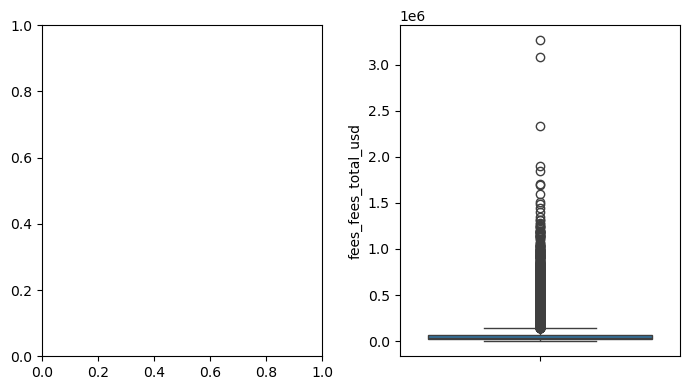

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

# Histogram plot on the first subplot (axes[0])
# sns.histplot(x='fees_fees_total_usd', data=eda, ax=axes[0])

# Box plot on the second subplot (axes[1])
sns.boxplot(y='fees_fees_total_usd', data=eda, ax=axes[1])

# Show the plot
plt.tight_layout()
plt.show()
# clip 필수!


In [47]:
#nan
missing_values=eda.isnull().sum()
percentage_values=100*missing_values/len(missing_values)
check=percentage_values.sort_values(ascending=False)
check

transactions-count_transactions_count_mean      44.186047
block-interval_block_interval                   44.186047
fees_fees_block_mean                            44.186047
fees_fees_reward_percent                        44.186047
fees-transaction_fees_transaction_mean          44.186047
tokens-transferred_tokens_transferred_mean      44.186047
fees-transaction_fees_transaction_mean_usd      44.186047
fees_fees_block_mean_usd                        44.186047
difficulty_difficulty                           44.186047
block-bytes_block_bytes                         44.186047
coinbase_premium_index                          11.627907
coinbase_premium_gap                            11.627907
fees_fees_total                                  0.000000
velocity_velocity_supply_total                   0.000000
fees-transaction_fees_transaction_median         0.000000
supply_supply_total                              0.000000
short_liquidations_usd                           0.000000
long_liquidati

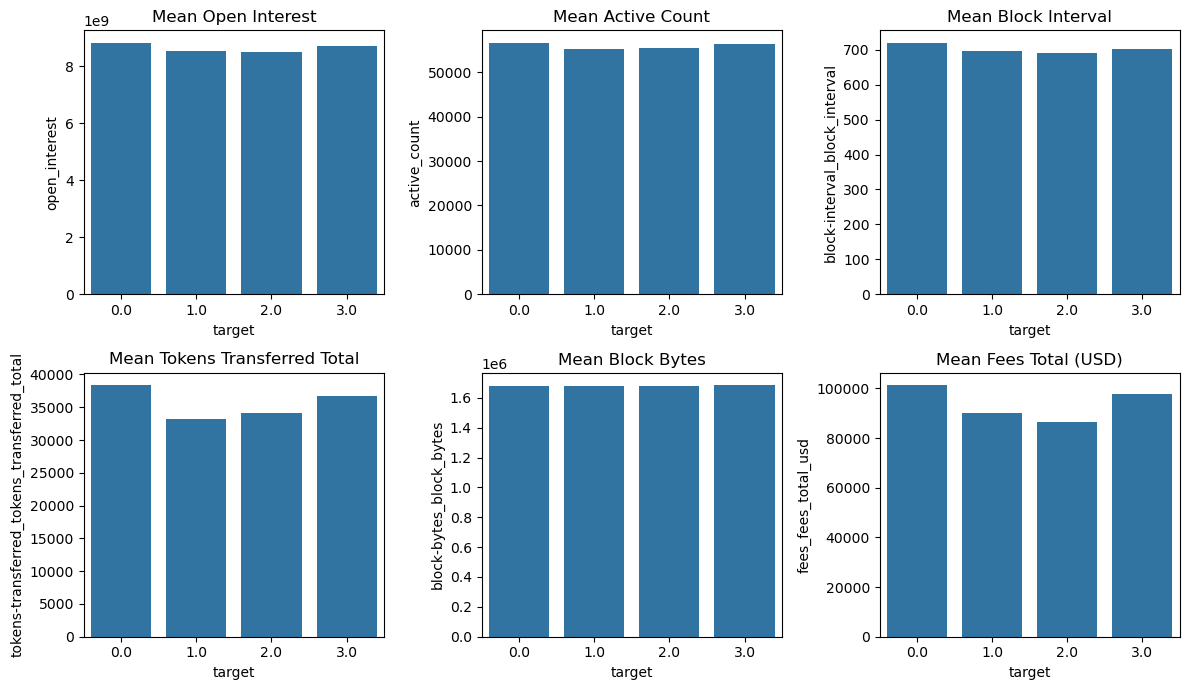

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'group_eda' is already computed as shown in your code
fig, axes = plt.subplots(2, 3, figsize=(12, 7))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Bar plot for 'open_interest'
sns.barplot(x=group_eda.index, y='open_interest', ax=axes[0], data=group_eda)
axes[0].set_title('Mean Open Interest')

# Bar plot for 'active_count'
sns.barplot(x=group_eda.index, y='active_count', ax=axes[1], data=group_eda)
axes[1].set_title('Mean Active Count')

# Bar plot for 'block-interval_block_interval'
sns.barplot(x=group_eda.index, y='block-interval_block_interval', ax=axes[2], data=group_eda)
axes[2].set_title('Mean Block Interval')

# Bar plot for 'tokens-transferred_tokens_transferred_total'
sns.barplot(x=group_eda.index, y='tokens-transferred_tokens_transferred_total', ax=axes[3], data=group_eda)
axes[3].set_title('Mean Tokens Transferred Total')

# Bar plot for 'block-bytes_block_bytes'
sns.barplot(x=group_eda.index, y='block-bytes_block_bytes', ax=axes[4], data=group_eda)
axes[4].set_title('Mean Block Bytes')

# Bar plot for 'fees_fees_total_usd'
sns.barplot(x=group_eda.index, y='fees_fees_total_usd', ax=axes[5], data=group_eda)
axes[5].set_title('Mean Fees Total (USD)')

# Adjust layout
plt.tight_layout()
plt.show()


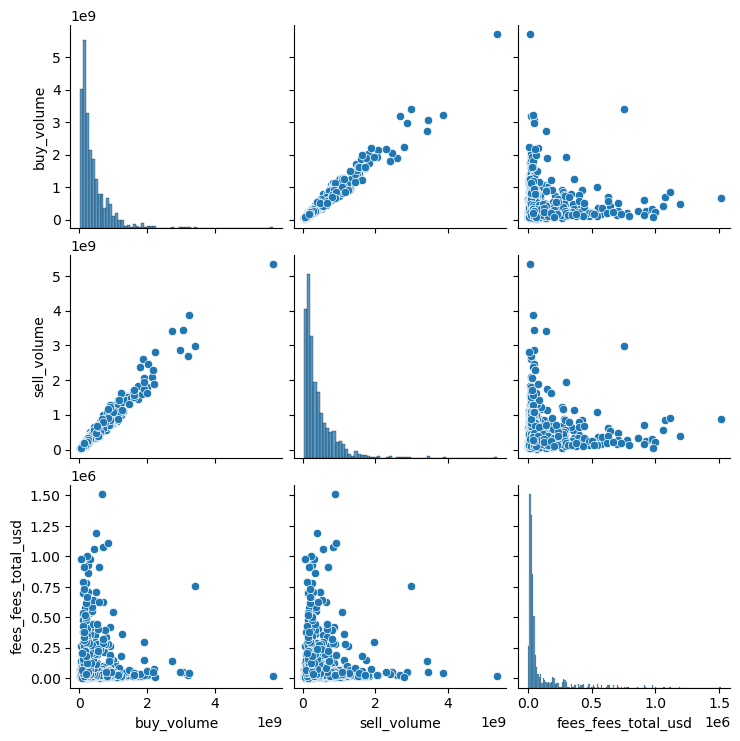

In [51]:
d={}
eda.groupby('target')[['buy_volume','sell_volume','fees_fees_total_usd']]
for target, dataframe in eda.groupby('target')[['buy_volume','sell_volume','fees_fees_total_usd']]:
    d[target]=dataframe
sns.pairplot(data=d[3])
# plt.show()

# Fees total + Tokens Transferred total is related to target!

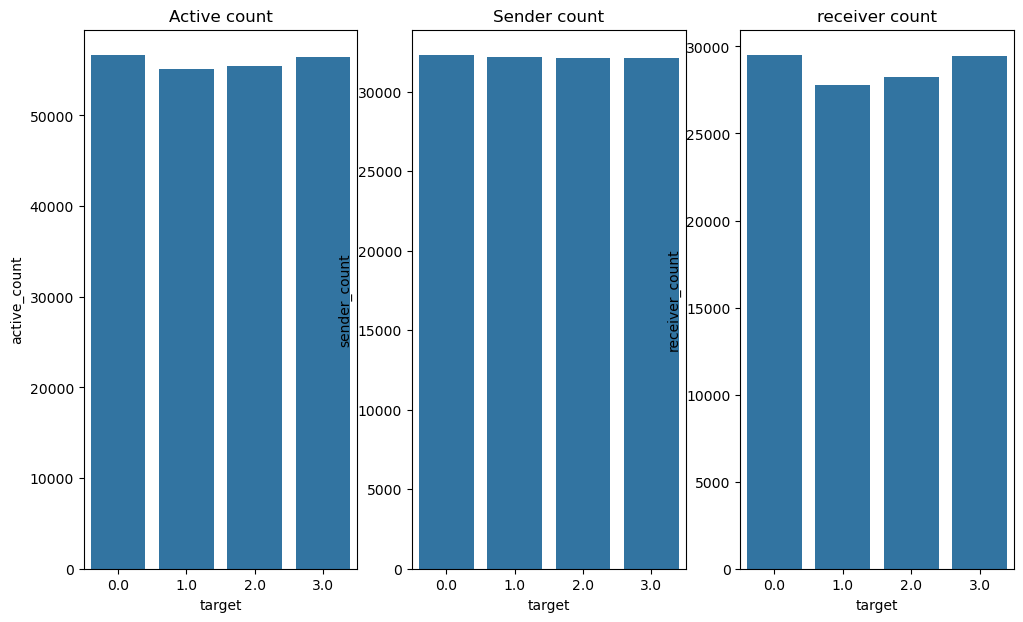

target
0.0   -2789.475676
1.0   -4362.088600
2.0   -3856.838191
3.0   -2687.875776
dtype: float64

In [37]:
group_eda=eda.groupby("target")[['open_interest','sender_count','receiver_count']].mean()

fig, axes = plt.subplots(1, 3, figsize=(12, 7))
axes=axes.flatten()
sns.barplot(x=group_eda.index,y='active_count',data=group_eda,ax=axes[0])
axes[0].set_title('Active count')

sns.barplot(x=group_eda.index,y='sender_count',data=group_eda,ax=axes[1])
axes[1].set_title('Sender count')

sns.barplot(x=group_eda.index,y='receiver_count',data=group_eda,ax=axes[2])
axes[2].set_title('receiver count')
plt.show()
group_eda.loc[:,'receiver_count']-group_eda.loc[:,'sender_count']


block-byte does not really count? i guess